In [1]:
import config
C = config.get_config('./config/024_3tail_avgpool2.yml')

config:  {'submission': False, 'batch_size': 256, 'device': 'cuda:0', 'out': '.', 'image_size': [64, 64], 'arch': 'pretrained', 'model_name': 'se_resnext50_32x4d', 'use_class_weight': True, 'datadir': PosixPath('../input/bengaliai-cv19'), 'featherdir': PosixPath('../input/bengaliaicv19feather'), 'pngdir': PosixPath('../input/bengaliai-cv19-png'), 'outdir': '../run/024_3tail_avgpool2.yml', 'n_epoch': 90, 'num_workers': 4, 'num_classes': [168, 11, 7], 'fold': 0, 'scheduler': 'Adam', 'lr': 5e-07, 'crop_pad_size': 0, 'aug_scale': [0.0, 0.0], 'aug_rot': 7}


In [4]:
from dataset import *
from loss import *

In [6]:
t, v = get_trainval_dataset_png()

(200840,)
(200840, 3)
  image_id  fold
0  Train_0     3
1  Train_1     2
2  Train_2     4
3  Train_3     2
4  Train_4     1
pre-split fold loaded, valid_indices:(array([     9,     12,     20, ..., 200830, 200834, 200835]),)
train_dataset 160672 valid_dataset 40168


81
2
2


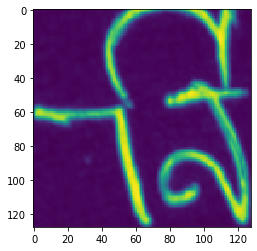

In [5]:
im, la = t[3]
#print( im.shape )
#print( la.shape )
print( la[0] )
print( la[1] )
print( la[2] )

import matplotlib.pyplot as plt
plt.imshow(im[0])
plt.show()

115
0
0


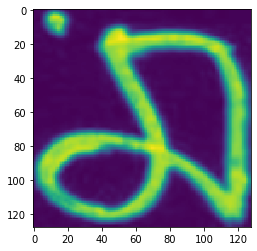

In [6]:
im, la = v[3]
print( la[0] )
print( la[1] )
print( la[2] )

import matplotlib.pyplot as plt
plt.imshow(im[0])
plt.show()

In [7]:
t.image_ids[:5]

array(['Train_113174', 'Train_148501', 'Train_33118', 'Train_6758',
       'Train_14808'], dtype=object)

In [8]:
v.image_ids[:5]

array(['Train_102202', 'Train_177348', 'Train_96665', 'Train_87926',
       'Train_164740'], dtype=object)

# GridMask

In [32]:
from torch.utils.data.dataloader import DataLoader
dl = DataLoader(t, batch_size=1, shuffle=True)

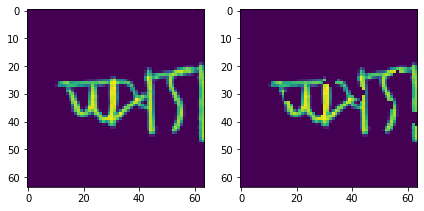

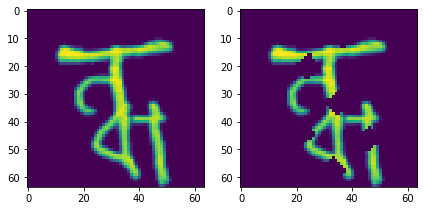

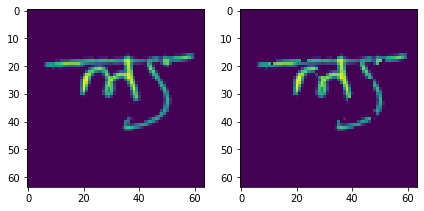

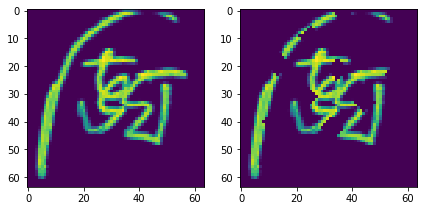

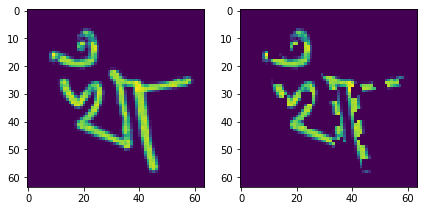

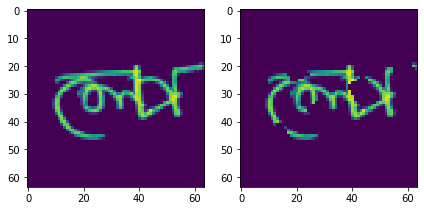

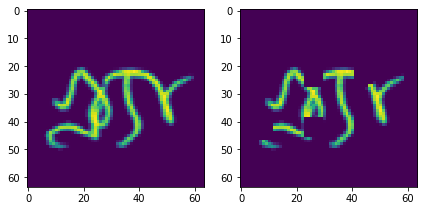

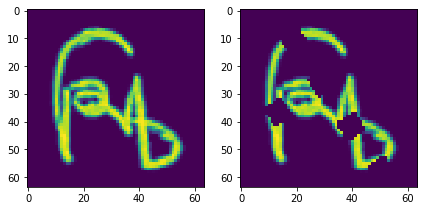

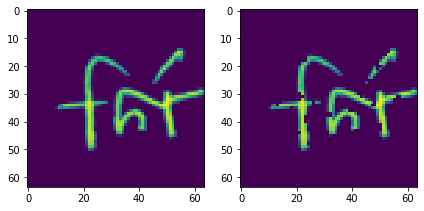

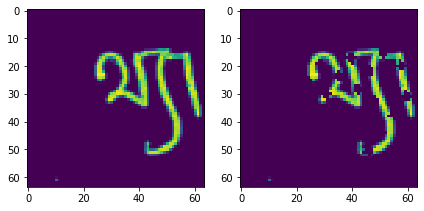

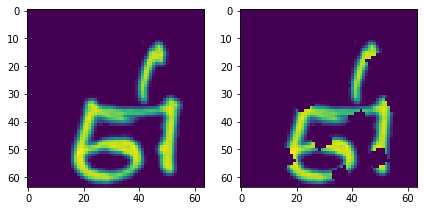

In [41]:
from trans import GridMask
gm = GridMask(C.image_size[0] * 0.1, C.image_size[0] * 0.4, ratio=0.6, rotate=360, mode=1)

i = 0
for x, y in dl:
    x_aug = gm(x)
    
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.imshow(x[0][0])
    plt.subplot(1,2,2)
    plt.imshow(x_aug[0][0])
    plt.title("")
    plt.show()
    
    i += 1
    if i > 10 : break

### mixup

In [15]:
from torch.utils.data.dataloader import DataLoader
dl = DataLoader(t, batch_size=4, shuffle=True)


<class 'torch.Tensor'>
torch.Size([4])
<class 'torch.Tensor'>
torch.Size([4])
<class 'torch.Tensor'>
torch.Size([4])


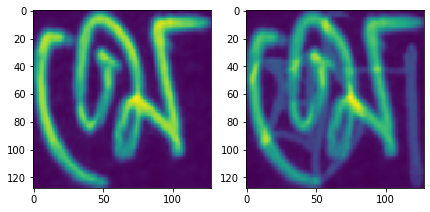

<class 'torch.Tensor'>
torch.Size([4])
<class 'torch.Tensor'>
torch.Size([4])
<class 'torch.Tensor'>
torch.Size([4])


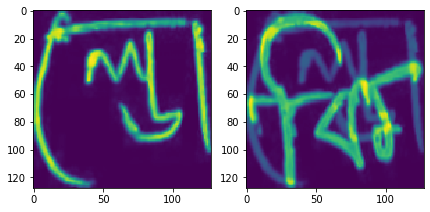

In [11]:
i = 0
for x, y in dl:
    #print(y[0].shape)
    
    ## [B,3] -> [3, B]
    mix_x, mix_y1, mix_y2, mix_y3 = mixup_multi_targets(x, y[:, 0], y[:, 1], y[:, 2])
    #print(mix_x.shape)
    
    l1 = mix_y1[0]
    l2 = mix_y2[1]
    l3 = mix_y3[2]
    #print(l1.shape)
    #print(l2.shape)
    #print(l3.shape)
    #print(l1)
    
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.imshow(x[0][0])
    plt.subplot(1,2,2)
    plt.imshow(mix_x[0][0])
    plt.title("")
    plt.show()
    
    i += 1
    if i >= 2 : break

In [12]:
BS = 2
C = 3
y_pred = torch.from_numpy( np.array( [ [0, .2, .8], [0, 0, 1] ,[0.9, 0., 0.1] ] ) )

y_onehot      = torch.from_numpy( np.array( [ [0,0,1], [0,0,1] ,[0,0,1] ] ) )
y      = torch.from_numpy( np.array( [2,2,2] ) )

#mixup_cross_entropy_loss()
y_pred

print( torch.nn.functional.cross_entropy(y_pred, y) )
print( mixup_cross_entropy_loss(y_pred, y_onehot) )

tensor(0.8873, dtype=torch.float64)
tensor(0.8873, dtype=torch.float64)


In [17]:
print(y)

tensor([2, 2, 2])


In [13]:
y_onehot_2 = torch.from_numpy( np.array( [ [0, .2, .8], [0,0,1] ,[0.9, 0, 0.1] ] ) )

### perfect pred
print( mixup_cross_entropy_loss(y_pred, y_onehot_2) )

tensor(0.6873, dtype=torch.float64)


In [14]:
### bad pred 1
y_pred_2 = torch.from_numpy( np.array( [ [.9, .1, .0], [0, 0.5, 0.5] ,[0.1, 0.4, 0.5] ] ) )

print( mixup_cross_entropy_loss(y_pred_2, y_onehot_2) )


tensor(1.2541, dtype=torch.float64)


In [15]:
### bad pred 3
y_pred_3 = torch.from_numpy( np.array( [ [1./3, 1./3, 1./3], [1./3, 1./3, 1./3] ,[1./3, 1./3, 1./3] ] ) )

print( mixup_cross_entropy_loss(y_pred_3, y_onehot_2) )


tensor(1.0986, dtype=torch.float64)


In [16]:
y_pred = y_pred_3.to('cuda:0')

y_pred

tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)